# Katib parameter tuning over Kubeflow Pipelines (V1)

This example shows how parameter tunning can be done over a multistep Kubeflow pipeline.

The pipeline consists of 4 steps:
- Download of the training images and labels from the original MNIST publication
- Prepartion of the training dataset
- Image pre-processing
- Model fitting

The pipeline has the model has model fitting parameters as well as image pre-processing parameters exposed as a pipeline parameter for tuning. Katib will be used to explore the question if image preprocessing using a simple histogram normalization might improve a neural network training on MNIST.

## Requirements

This requires a Kubeflow installation with Katib and Pipelines.

Additionally the Katib-Argo integration needs to be setup:

If you are running on a full Kubeflow installation *do not reinstall or update Argo* as this will likely break your installation.

Just run the following commands:

Enable side-car injection:

`kubectl patch namespace argo -p '{"metadata":{"labels":{"katib.kubeflow.org/metrics-collector-injection":"enabled"}}}'`


Verify that the emissary executor is active (should be default in newer Kubeflow installations):

` kubectl get ConfigMap -n argo workflow-controller-configmap -o yaml | grep containerRuntimeExecutor`

Patch the Katib controller:

`kubectl patch ClusterRole katib-controller -n kubeflow --type=json \
  -p='[{"op": "add", "path": "/rules/-", "value": {"apiGroups":["argoproj.io"],"resources":["workflows"],"verbs":["get", "list", "watch", "create", "delete"]}}]'
`

`kubectl patch Deployment katib-controller -n kubeflow --type=json \
  -p='[{"op": "add", "path": "/spec/template/spec/containers/0/args/-", "value": "--trial-resources=Workflow.v1alpha1.argoproj.io"}]'`

For more details and how to set this up on a partial Kubeflow installation follow:
https://github.com/kubeflow/katib/tree/master/examples/v1beta1/argo/README.mdd

## Building the base Kubeflow pipeline

The next steps will build up the following Kubeflow pipeline:

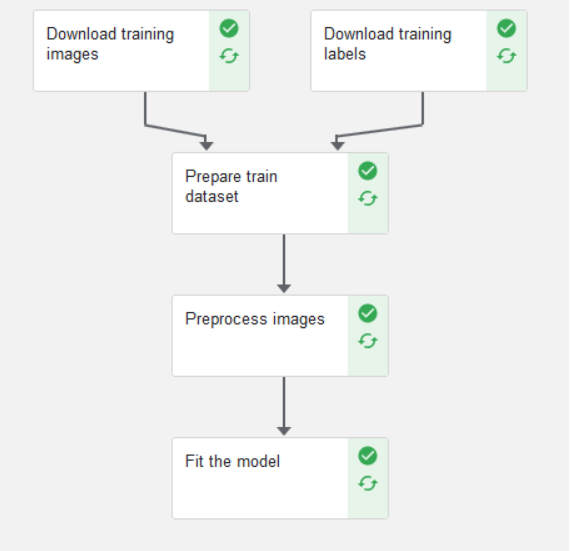

## Set default variables

The following default variables should be changed when running the notebook

In [ ]:
# Namespace to run the workloads under
USER_NAMESPACE = "vito-zanotelli"
# Pipeline service account
# On a Kubeflow instance on GCP this should be 'default-editor'
KFP_SERVICE_ACCOUNT = "default-editor"


# Consmetic variables
# Pipeline run variables
KFP_EXPERIMENT = "katib-kfp-example"
KFP_RUN = "mnist-pipeline-v1"

# Katib run variables
KATIB_EXPERIMENT = "katib-kfp-example-v1"

### Install and load required python packages

In [ ]:
# Install required packages (Kubeflow Pipelines and Katib SDK).
!pip install kfp==1.8.12
!pip install kubeflow-katib==0.13.0

In [ ]:
from typing import Optional
from datetime import datetime as dt
import kfp
import kfp.components as components
import kfp.dsl as dsl
from kfp.components import InputPath, OutputPath, create_component_from_func

### Initialize the Kubeflow pipeline client

Documentation how this is done in various environments: https://www.kubeflow.org/docs/components/pipelines/v1/sdk/connect-api/

In [ ]:
kfp_client = kfp.Client()

### Get the downloader component

This is a publicly available, generic downloader we use to download the raw MNIST data

In [ ]:
download_data_op = components.load_component_from_url(
    "https://raw.githubusercontent.com/kubeflow/pipelines/master/components/contrib/web/Download/component.yaml"
)

### Parse the MNIST raw data format

This is a component from text that converts the raw MNIST data format into a tensorflow compatible format.

In [ ]:
parse_mnist_op = components.load_component_from_text(
    """
name: Parse MNIST
inputs:
- {name: Images, description: gziped images in the idx format}
- {name: Labels, description: gziped labels in the idx format}
outputs:
- {name: Dataset}
metadata:
  annotations:
    author: Vito Zanotelli, D-ONE.ai
    description: Based on https://github.com/kubeflow/pipelines/blob/master/components/contrib/sample/Python_script/component.yaml
implementation:
  container:
    image: tensorflow/tensorflow:2.7.1
    command:
    - sh
    - -ec
    - |
      # This is how additional packages can be installed dynamically
      python3 -m pip install pip idx2numpy
      # Run the rest of the command after installing the packages.
      "$0" "$@"
    - python3
    - -u  # Auto-flush. We want the logs to appear in the console immediately.
    - -c  # Inline scripts are easy, but have size limitaions and the error traces do not show source lines.
    - |
      import gzip
      import idx2numpy
      import sys
      from pathlib import Path
      import pickle
      import tensorflow as tf
      img_path = sys.argv[1]
      label_path = sys.argv[2]
      output_path = sys.argv[3]
      with gzip.open(img_path, 'rb') as f:
        x = idx2numpy.convert_from_string(f.read())
      with gzip.open(label_path, 'rb') as f:
        y = idx2numpy.convert_from_string(f.read())
      #one-hot encode the categories
      x_out = tf.convert_to_tensor(x)
      y_out = tf.keras.utils.to_categorical(y)
      Path(output_path).parent.mkdir(parents=True, exist_ok=True)
      with open(output_path, 'wb') as output_file:
            pickle.dump((x_out, y_out), output_file)
    - {inputPath: Images}
    - {inputPath: Labels}
    - {outputPath: Dataset}
"""
)

### Process the images

This does the pre-processing of the images, including a training-validation split.

Here also an optional `histogram_norm` image normalization step can be activated

In [ ]:
def process(
    data_raw_path: InputPath(str),  # type: ignore
    data_processed_path: OutputPath(str),  # type: ignore
    val_pct: float = 0.2,
    trainset_flag: bool = True,
    histogram_norm: bool = False,
):
    """
    Here we do all the preprocessing
    if the data path is for training data we:
    (1) Normalize the data
    (2) split the train and val data
    If it is for unseen test data, we:
    (1) Normalize the data
    This function returns in any case the processed data path
    """
    # sklearn
    import pickle
    from sklearn.model_selection import train_test_split
    import tensorflow as tf
    import tensorflow_addons as tfa

    def img_norm(x):
        x_ = tf.reshape(x, list(x.shape) + [1])

        if histogram_norm:
            x_ = tfa.image.equalize(x_)

        # Scale between 0-1
        x_ = x_ / 255
        return x_

    with open(data_raw_path, "rb") as f:
        x, y = pickle.load(f)
    if trainset_flag:

        x_ = img_norm(x)
        x_train, x_val, y_train, y_val = train_test_split(
            x_.numpy(), y, test_size=val_pct, stratify=y, random_state=42
        )

        with open(data_processed_path, "wb") as output_file:
            pickle.dump((x_train, y_train, x_val, y_val), output_file)

    else:
        x_ = img_norm(x)
        with open(data_processed_path, "wb") as output_file:
            pickle.dump((x_, y), output_file)

In [ ]:
process_op = create_component_from_func(
    func=process,
    base_image="tensorflow/tensorflow:2.7.1",  # Optional
    packages_to_install=["scikit-learn", "tensorflow-addons[tensorflow]"],  # Optional
)

### Training component

Component with ML hyperparameters as parameters.
Note that the `metrics` that should be tracked by Katib need to be
saved as ML metrics output artifacts.


In [ ]:
def train(
    data_train_path: InputPath(str),  # type: ignore
    model_out_path: OutputPath(str),  # type: ignore
    mlpipeline_metrics_path: OutputPath("Metrics"),  # type: ignore # noqa: F821
    lr: float = 1e-4,
    optimizer: str = "Adam",
    loss: str = "categorical_crossentropy",
    epochs: int = 1,
    batch_size: int = 32,
):
    """
    This is the simulated train part of our ML pipeline where training is performed
    """

    import tensorflow as tf
    import pickle
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    import json

    with open(data_train_path, "rb") as f:
        x_train, y_train, x_val, y_val = pickle.load(f)

    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                64, (3, 3), activation="relu", input_shape=(28, 28, 1)
            ),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(10, activation="softmax"),
        ]
    )

    if optimizer.lower() == "sgd":
        optimizer = tf.keras.optimizers.SGD(lr)
    else:
        optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

    # fit the model
    model_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=10, verbose=1, restore_best_weights=True
    )

    train_datagen = ImageDataGenerator()

    validation_datagen = ImageDataGenerator()
    history = model.fit(
        train_datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=validation_datagen.flow(x_val, y_val, batch_size=batch_size),
        shuffle=False,
        callbacks=[model_early_stopping_callback],
    )

    model.save(model_out_path, save_format="tf")

    metrics = {
        "metrics": [
            {
                "name": "accuracy",  # The name of the metric. Visualized as the column name in the runs table.
                "numberValue": history.history["accuracy"][
                    -1
                ],  # The value of the metric. Must be a numeric value.
                "format": "PERCENTAGE",  # The optional format of the metric. Supported values are "RAW" (displayed in raw format) and "PERCENTAGE" (displayed in percentage format).
            },
            {
                "name": "val-accuracy",  # The name of the metric. Visualized as the column name in the runs table.
                "numberValue": history.history["val_accuracy"][
                    -1
                ],  # The value of the metric. Must be a numeric value.
                "format": "PERCENTAGE",  # The optional format of the metric. Supported values are "RAW" (displayed in raw format) and "PERCENTAGE" (displayed in percentage format).
            },
        ]
    }
    with open(mlpipeline_metrics_path, "w") as f:
        json.dump(metrics, f)


train_op = create_component_from_func(
    func=train, base_image="tensorflow/tensorflow:2.7.1", packages_to_install=["scipy"]
)

### Build the full pipeline

These wires the components to a full pipeline.

The only thing required to make the pipeline Katib compatible is:

1) A pod label to mark the pod from which the metrics tracked by Katib should be collected from: "katib.kubeflow.org/model-training", "true"
2) A mark to prevent caching on this pod: `execution_options.caching_strategy.max_cache_staleness = "P0D"`

In addition, currently the pod label for caching seems not be added by default and thus the cache is not used. To enable cache usage, the cache label is added to all the steps.

Apart from these two requirements, there is no restriction on how the pipeline is build. The pipeline remains a normal Kubeflow pipeline.

In [ ]:
def _label_cache(step):
    """Helper to add pod cache label

    Currently there seems to be an issue with pod labeling.
    """
    step.add_pod_label("pipelines.kubeflow.org/cache_enabled", "true")

In [ ]:
@dsl.pipeline(
    name="Download MNIST dataset",
    description="A pipeline to download the MNIST dataset files",
)
def mnist_training_pipeline(
    lr: float = 1e-4,
    optimizer: str = "Adam",
    loss: str = "categorical_crossentropy",
    epochs: int = 3,
    batch_size: int = 5,
    histogram_norm: bool = False,
):
    TRAIN_IMG_URL = "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"
    TRAIN_LAB_URL = "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"

    train_imgs = download_data_op(TRAIN_IMG_URL)
    train_imgs.set_display_name("Download training images")
    _label_cache(train_imgs)

    train_y = download_data_op(TRAIN_LAB_URL)
    train_y.set_display_name("Download training labels")
    _label_cache(train_y)

    mnist_train = parse_mnist_op(train_imgs.output, train_y.output)
    mnist_train.set_display_name("Prepare train dataset")
    _label_cache(mnist_train)

    processed_train = (
        process_op(
            mnist_train.output,
            val_pct=0.2,
            trainset_flag=True,
            histogram_norm=histogram_norm,
        )
        .set_cpu_limit("1")
        .set_memory_limit("2Gi")
        .set_display_name("Preprocess images")
    )
    _label_cache(processed_train)

    training_output = (
        train_op(
            processed_train.outputs["data_processed"],
            lr=lr,
            optimizer=optimizer,
            epochs=epochs,
            batch_size=batch_size,
            loss=loss,
        )
        .set_cpu_limit("1")
        .set_memory_limit("2Gi")
    )
    training_output.set_display_name("Fit the model")
    # This pod label indicates which pod Katib should collect the metric from.
    # A metrics collecting sidecar container will be added
    training_output.add_pod_label("katib.kubeflow.org/model-training", "true")
    # This step needs to run always, as otherwise the metrics for Katib could not
    # be collected.
    training_output.execution_options.caching_strategy.max_cache_staleness = "P0D"

    return mnist_train.output

In [ ]:
kfp_run = f"{KFP_RUN}-{dt.today().strftime('%Y-%m-%d-%Hh-%Mm-%Ss')}"
run = kfp_client.create_run_from_pipeline_func(
    mnist_training_pipeline,
    mode=kfp.dsl.PipelineExecutionMode.V1_LEGACY,
    # You can optionally override your pipeline_root when submitting the run too:
    # pipeline_root='gs://my-pipeline-root/example-pipeline',
    arguments={"histogram_norm": "0"},
    experiment_name=KFP_EXPERIMENT,
    run_name=kfp_run,
    namespace=USER_NAMESPACE,
)

# Parameter tuning with Katib

We now want to do parameter tuning over the whole pipeline with Katib.

This requires us to build up a specificaiton for the Katib experiment

First import the Katib python components:

In [ ]:
import yaml
from typing import List

from kubernetes.client.models import V1ObjectMeta
from kubeflow.katib import ApiClient
from kubeflow.katib import KatibClient
from kubeflow.katib import V1beta1Experiment
from kubeflow.katib import V1beta1ExperimentSpec
from kubeflow.katib import V1beta1AlgorithmSpec
from kubeflow.katib import V1beta1ObjectiveSpec
from kubeflow.katib import V1beta1ParameterSpec
from kubeflow.katib import V1beta1FeasibleSpace
from kubeflow.katib import V1beta1TrialTemplate
from kubeflow.katib import V1beta1TrialParameterSpec
from kubeflow.katib import V1beta1MetricsCollectorSpec
from kubeflow.katib import V1beta1CollectorSpec

In order to build a katib experiment, we require a trial spec.

In this case the trial spec is an Argo workflow produced form the Kubeflow pipeline.

This workflow can be run thanks to the Katib-Argo integration that was setup in the requirements section.


The Katib Experiment consists of many components, that we next will setup using custom built helper functions:

### Helper functions to build the individual Katib Experiment Components


In [ ]:
def create_trial_spec(
    pipeline,
    params_list: List[dsl.PipelineParam],
    service_account: Optional[str] = None,
):
    """
    Create an Argo workflow specification from a KFP pipeline function

    The Argo worklow CRD will be the basis for the trial_template used
    by Katib.

    Args:
        pipeline: a kubeflow pipeline function
        params_list (List[dsl.PipelineParam]): a list of mappings of Kubeflow pipeline parameters
            to Katib trialParameters.
            These need to map the pipeline parameter to the Katib parameter.
            Eg: [dsl.PipelineParam(name='lr', value='${trialParameters.learningRate}')]
            here `lr` is the PipelineParam and `trialParameters.learningRate` the Katib trialParameter.

    """
    compiler = kfp.compiler.Compiler(
        mode=kfp.dsl.PipelineExecutionMode.V1_LEGACY,
    )
    # Here the pipeline parameters are passed.
    # These will be generated in the Katib trials
    trial_spec = compiler._create_workflow(pipeline, params_list=params_list)
    # Somehow the pipeline is configured with the wrong serviceAccountName by default
    if service_account is not None:
        trial_spec["spec"]["serviceAccountName"] = service_account

    return trial_spec

In [ ]:
def create_trial_template(
    trial_spec,
    trial_param_specs: List[V1beta1TrialParameterSpec],
    retain_pods: bool = False,
) -> V1beta1TrialTemplate:
    """Generate a trial template from the spec

    This takes the Argo workflow CRD and wrapps it as a
    Katib trial template.
    Here the Katib trial parameters are defined.

    Args:
        trial_spec (Argo workflow spec): The workflow/pipeline to tune
        trial_params_spec (List[V1beta1TrialParameterSpec]): The trial parameter specifications
            Note that the `name` of the parameters needs to match the names refered to by the
            create_trial_spec `params_list` arguments.
            The `ref` needs to match the names used in the parameter space defined in `V1beta1ParameterSpec`.

    Returns:
        V1beta1TrialTemplate: the trial template
    """

    trial_template = V1beta1TrialTemplate(
        primary_container_name="main",  # Name of the primary container returning the metrics in the workflow
        # The label used for the pipeline component returning the pipeline specs
        primary_pod_labels={"katib.kubeflow.org/model-training": "true"},
        trial_parameters=trial_param_specs,
        trial_spec=trial_spec,
        success_condition='status.[@this].#(phase=="Succeeded")#',
        failure_condition='status.[@this].#(phase=="Failed")#',
        retain=retain_pods,  # Retain completed pods - left hear for easier debugging
    )
    return trial_template

In [ ]:
def create_metrics_collector_spec(objective: V1beta1ObjectiveSpec):
    """This defines the custom metrics collector

    This custom metrics connector was built to collect
    Kubeflow pipeline MLmetrics from a step.

    Args:
        objective (V1beta1ObjectiveSpec): the objective spec used to get the metrics names

    """

    metric_names = [objective.objective_metric_name] + list(
        objective.additional_metric_names
    )
    collector = V1beta1MetricsCollectorSpec(
        source={
            "fileSystemPath": {
                # In KFP v1 this seems to be the hardcoded location
                # for this output file..
                "path": "/tmp/outputs/mlpipeline_metrics/data",
                "kind": "File",
            }
        },
        collector=V1beta1CollectorSpec(
            kind="Custom",
            custom_collector={
                "args": [
                    "-m",
                    f"{';'.join(metric_names)}",
                    "-s",
                    "katib-db-manager.kubeflow:6789",
                    "-t",
                    "$(PodName)",
                    "-path",
                    "/tmp/outputs/mlpipeline_metrics",
                ],
                "image": "docker.io/kubeflowkatib/kfpv1-metrics-collector:latest",
                "imagePullPolicy": "Always",
                "name": "custom-metrics-logger-and-collector",
                "env": [
                    {
                        # In this setup the PodName can be used to
                        # infer the `trial name` required to report back
                        # the metrics.
                        "name": "PodName",
                        "valueFrom": {"fieldRef": {"fieldPath": "metadata.name"}},
                    }
                ],
            },
        ),
    )
    return collector

### Final helper function to create experiments from pipelines


This helper function is the main entry point to train pipelines.

In [ ]:
def create_katib_experiment_spec(
    pipeline: dsl.Pipeline,
    pipeline_params: List[dsl.PipelineParam],
    trial_params: List[V1beta1TrialParameterSpec],
    trial_params_space: List[V1beta1ParameterSpec],
    objective: V1beta1ObjectiveSpec,
    algorithm: V1beta1AlgorithmSpec,
    max_trial_count: int = 2,
    max_failed_trial_count: int = 2,
    parallel_trial_count: int = 2,
    pipeline_service_account: Optional[str] = None,
    retain_pods: bool = False,
) -> V1beta1ExperimentSpec:
    """Construct a Katib experiment over a KFP pipeline

    Args:
        pipeline (dsl.Pipeline): The Kubeflow Pipeline
        pipeline_params (List[dsl.PipelineParam]): A mapping of  trial-parameters to pipeline parameters.
            Example: [
                    dsl.PipelineParam(name="lr", value="${trialParameters.learningRate}"),
                    ...
                    ]
        trial_params (List[V1beta1TrialParameterSpec]): Spec for Trial parameters. Note that name
            and refs need to match the ones used in `pipeline_params` and `trial_params_space`
            Example: [
                    V1beta1TrialParameterSpec(
                        name="learningRate",
                        description="Learning rate for the training model",
                        reference="learning_rate",
                    ), ...]
        trial_params_space (List[V1beta1ParameterSpec]): The spec for the parameter space explored in the
            Trials
            Example: [
                V1beta1ParameterSpec(
                    name="learning_rate",
                    parameter_type="double",
                    feasible_space=V1beta1FeasibleSpace(min="0.00001", max="0.001"),
                ), ...]
        objective (V1beta1ObjectiveSpec): objective spec. The names used here
            need to match the metrics reported by the pipeline.
            Example: V1beta1ObjectiveSpec(
                    type="maximize",
                    goal=0.9,
                    objective_metric_name="val-accuracy",
                    additional_metric_names=["accuracy"],
                )
        algorithm (V1beta1AlgorithmSpec): algorithm spec
            Example: V1beta1AlgorithmSpec(
                        algorithm_name="random",
                    )
        max_trial_count (int, optional): Max total number of trials. Defaults to 2.
        max_failed_trial_count (int, optional): Number of failed trials tolerated. Defaults to 2.
        parallel_trial_count (int, optional): Number of trials run in parallel. Defaults to 2.
        pipeline_service_account (str | None, optional): Name of the service account to run
            pipelines with. Defaults to None (uses pre-configured default).
            On a Kubeflow GCP deployment this should be set to `default-editor`
        retain_pods (bool): retain pods (good for debugging). Default: false

    Returns:
        V1beta1ExperimentSpec: Katib experiment spec
    """

    trial_spec = create_trial_spec(
        pipeline, pipeline_params, service_account=pipeline_service_account
    )

    # Configure parameters for the Trial template.
    trial_template = create_trial_template(
        trial_spec, trial_params, retain_pods=retain_pods
    )

    # Metrics collector spec
    metrics_collector = create_metrics_collector_spec(objective=objective)

    # Create an Experiment from the above parameters.
    experiment_spec = V1beta1ExperimentSpec(
        # Experimental Budget
        max_trial_count=max_trial_count,
        max_failed_trial_count=max_failed_trial_count,
        parallel_trial_count=parallel_trial_count,
        # Optimization Objective
        objective=objective,
        # Optimization Algorithm
        algorithm=algorithm,
        # Optimization Parameters
        parameters=trial_params_space,
        # Trial Template
        trial_template=trial_template,
        # Metrics collector
        metrics_collector_spec=metrics_collector,
    )

    return experiment_spec

### Tune the MNIST pipeline using Katib

First prepare all required input

In [ ]:
pipeline_params = [
    dsl.PipelineParam(name="lr", value="${trialParameters.learningRate}"),
    dsl.PipelineParam(name="batch_size", value="${trialParameters.batchSize}"),
    dsl.PipelineParam(name="histogram_norm", value="${trialParameters.histogramNorm}"),
]
trial_params_specs = [
    V1beta1TrialParameterSpec(
        name="learningRate",  # the parameter name that is replaced in your template (see Trial Specification).
        description="Learning rate for the training model",
        reference="learning_rate",  # the parameter name that experiment’s suggestion returns (parameter name in the Parameters Specification).
    ),
    V1beta1TrialParameterSpec(
        name="batchSize",
        description="Batch size for NN training",
        reference="batch_size",
    ),
    V1beta1TrialParameterSpec(
        name="histogramNorm",
        description="Histogram normalization of image on?",
        reference="histogram_norm",
    ),
]
parameter_space = [
    V1beta1ParameterSpec(
        name="learning_rate",
        parameter_type="double",
        feasible_space=V1beta1FeasibleSpace(min="0.00001", max="0.001"),
    ),
    V1beta1ParameterSpec(
        name="batch_size",
        parameter_type="int",
        feasible_space=V1beta1FeasibleSpace(min="16", max="64"),
    ),
    V1beta1ParameterSpec(
        name="histogram_norm",
        parameter_type="discrete",
        feasible_space=V1beta1FeasibleSpace(list=["0", "1"]),
    ),
]
objective = V1beta1ObjectiveSpec(
    type="maximize",
    goal=0.9,
    objective_metric_name="val-accuracy",
    additional_metric_names=["accuracy"],
)

algorithm = V1beta1AlgorithmSpec(
    algorithm_name="random",
)

In [ ]:
# Prepare the full spec

katib_spec = create_katib_experiment_spec(
    pipeline=mnist_training_pipeline,
    pipeline_params=pipeline_params,
    trial_params=trial_params_specs,
    trial_params_space=parameter_space,
    objective=objective,
    algorithm=algorithm,
    pipeline_service_account=KFP_SERVICE_ACCOUNT,
    max_trial_count=5,
    parallel_trial_count=5,
    retain_pods=False,
)

In order to generate a full experiment the api_version, kind and namespace need to be defined:

In [ ]:
katib_experiment_name = (
    f"{KATIB_EXPERIMENT}-{dt.today().strftime('%Y-%m-%d-%Hh-%Mm-%Ss')}"
)
katib_experiment = V1beta1Experiment(
    api_version="kubeflow.org/v1beta1",
    kind="Experiment",
    metadata=V1ObjectMeta(
        name=katib_experiment_name,
        namespace=USER_NAMESPACE,
    ),
    spec=katib_spec,
)

The generated yaml can written out to submit via the web ui:

In [ ]:
with open(f"{KATIB_EXPERIMENT}.yaml", "w") as f:
    yaml.dump(ApiClient().sanitize_for_serialization(katib_experiment), f)

Or sumitted via the KatibClient:

In [ ]:
katib_client = KatibClient()

In [ ]:
katib_client.create_experiment(katib_experiment)

You should now be able to observe in the Web UI how the Katib
Experiment is running.

To see how the `Argo Workflows` are started, you can also check the Kubernetes cluster:

`kubectl get Workflow -n <namespace>`